In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pylab import *
import csv,os, glob
from sklearn.decomposition import PCA,IncrementalPCA,KernelPCA
import random
import pickle

In [2]:
XY=np.load("/gpfs/slac/staas/fs1/g/supercdms/tf/northwestern/users/franinsu/testRun3/XY60k.npz")
X=XY["X"]
Y=XY["Y"]
Yrange = np.array([2048,20])# Ymax-Ymin
N=len(X)
m_train = round(.95*N)
m_dev =  round(10/95*m_train)
idx = np.random.permutation(N)
X_train, X_test = X[idx[:m_train]], X[idx[m_train:]]
Y_train, Y_test = Y[idx[:m_train]], Y[idx[m_train:]]
#dev is subset of train but isn't actually used in training
X_dev, Y_dev  = X_train[-m_dev:], Y_train[-m_dev:]
print("Size train:",X_train.shape[0]-X_dev.shape[0])
print("Size dev:",X_dev.shape[0])
print("Size test:", X_test.shape[0])

Size train: 33539
Size dev: 3946
Size test: 1973


In [4]:
pca = IncrementalPCA(n_components=1024, batch_size=5000)
pca.fit(X_train[:round(0.2*(m_train-m_dev))])

IncrementalPCA(batch_size=5000, copy=True, n_components=1024, whiten=False)

In [5]:
with open('pca_20p_rbt.pkl', 'wb') as f:
        pickle.dump(pca, f, pickle.HIGHEST_PROTOCOL)

In [6]:
with open('/home/franinsu/notebooks/pca_20p_rbt.pkl', 'rb') as f:
    unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
    pca = unpickler.load()

In [ ]:
kpca = KernelPCA(kernel="rbf", n_components=1024)
# kpca.fit(X_train[:5000])
kpca.fit(X_train[:round(0.2*(m_train-m_dev))])

In [ ]:
with open('kpca_20p_rbt.pkl', 'wb') as f:
        pickle.dump(kpca, f, pickle.HIGHEST_PROTOCOL)

In [7]:
X_train_T = pca.transform(X_train)

In [35]:
seed = 32
n_input=X_train_T.shape[1]
learning_rate=0.0008
n_out = 1
fresh_variables = True
dropout_rate = [1.]*6 #[0.7,0.7,0.7,0.7,0.7]
sizes = [n_input,512,256,128,64,32,n_out]
EPOCHS = 2000
beta = 0.0001
weights = {}
biases = {}

# for i in range(len(sizes)-1):
#     weights['h'+str(i)] = tf.Variable(tf.random_normal([sizes[i], sizes[i+1]], seed=seed))
#     biases['b'+str(i)] = tf.Variable(tf.random_normal([sizes[i+1]], seed=seed))
initializer=tf.contrib.layers.xavier_initializer(seed=seed)
for i in range(len(sizes)-1):
    weights['h'+str(i)] = tf.Variable(initializer([sizes[i], sizes[i+1]]))
    biases['b'+str(i)] = tf.Variable(initializer([sizes[i+1]]))


# #defining placeholders
# #input image placeholder
x=tf.placeholder("float",[None,n_input])
#input label placeholder
y=tf.placeholder("float",[None,n_out])
prob= tf.placeholder_with_default([1.0]*(len(sizes)-1), shape=(len(sizes)-1))
device_name = "/device:GPU:0"

In [36]:
with tf.device(device_name):
    r = x
    for i in range(len(sizes)-2):
        r = tf.matmul(r,weights['h'+str(i)])
        r = tf.add(r,biases['b'+str(i)])
        r = tf.nn.relu(r)
        r = tf.nn.dropout(r,prob[i])
    r = tf.matmul(r,weights['h'+str(i+1)])
    r = tf.add(r,biases['b'+str(i+1)])
    r = tf.nn.relu(r)
    prediction = r
    regularizer = tf.nn.l2_loss(weights['h0'])
    for i in range(len(sizes)-2):
        regularizer += tf.nn.l2_loss(weights['h'+str(i+1)])
    loss = tf.reduce_mean((y - prediction)**2+beta*regularizer)
    train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver()

In [37]:
def mae(x_e,y_e):
    return 2048*np.mean(np.abs(sess.run(prediction,feed_dict={x:x_e,y:y_e})-y_e))

In [ ]:
#initialize variables
m_training = m_train-m_dev
batch_size = 128
n_iters = round(m_training/batch_size - 0.5)
# n_iters = 1
y0 = []
y1 = []
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    init=tf.global_variables_initializer()
#     init = tf.local_variables_initializer()
    sess.run(init)
    if(not fresh_variables): saver.restore(sess,"/home/franinsu/notebooks/model.ckpt")
    for j in range(EPOCHS):
        for iter in range(n_iters):
            batch_x=X_train_T[iter*batch_size:(iter+1)*batch_size]
            batch_y=Y_train[iter*batch_size:(iter+1)*batch_size,0:1]
            batch_x=batch_x.reshape((batch_size,n_input))
            sess.run(train, feed_dict={x: batch_x, y: batch_y,prob:dropout_rate})
            iter=iter+1
            #los=sess.run(loss,feed_dict={x:X_train_T[:-m_dev],y:Y_train[:-m_dev,0:1]})
        v0 = mae(X_train_T[:-m_dev],Y_train[:-m_dev,0:1])
        v1 = mae(X_train_T[-m_dev:],Y_train[-m_dev:,0:1])
        y0.append(v0)
        y1.append(v1)
#             mae=sess.run(score,feed_dict={x:X_train[:-m_dev],y:Y_train[:-m_dev,0:1],prob:0})
        if j % 20 ==0:
            print(v0,v1)
            print("For Epoch ", j)
    #             print("MAE: ",mae)
            #print("Loss ",los)
            print("_______PCA+NN________")
            save_path = saver.save(sess, "/home/franinsu/notebooks/model.ckpt")
    mae(X_train_T[:-m_dev],Y_train[:-m_dev,0:1])
    mae(X_train_T[-m_dev:],Y_train[-m_dev:,0:1])
#     mae(X_test,Y_test[:,0:1])

321.5957170029958 323.71676498080535
For Epoch  0
_______PCA+NN________
83.6532413029188 162.88851989034583
For Epoch  20
_______PCA+NN________
59.70064720814178 147.62929742564663
For Epoch  40
_______PCA+NN________
52.704534834038824 138.95395180518048
For Epoch  60
_______PCA+NN________
57.43401984414366 144.54237822790287
For Epoch  80
_______PCA+NN________
88.06778635535542 163.44058417790563
For Epoch  100
_______PCA+NN________
39.74968129380977 128.29468246746112
For Epoch  120
_______PCA+NN________
42.40798175040275 127.90829964283452
For Epoch  140
_______PCA+NN________
43.66523514515052 127.70194349177767
For Epoch  160
_______PCA+NN________
60.44676081608701 142.24784653862298
For Epoch  180
_______PCA+NN________
36.506137171493684 122.7987243992631
For Epoch  200
_______PCA+NN________
53.2036951697965 138.9275388335795
For Epoch  220
_______PCA+NN________
38.45913669810589 125.02800217486853
For Epoch  240
_______PCA+NN________
46.104349742411586 126.86157913324014
For Epoc

(0, 337.5308533178872)

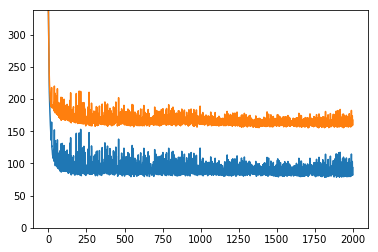

In [21]:
plt.plot(y0,label="training")
plt.plot(y1,label="dev")
plt.ylim([0,max(y1)])

(0, 327.55120029826486)

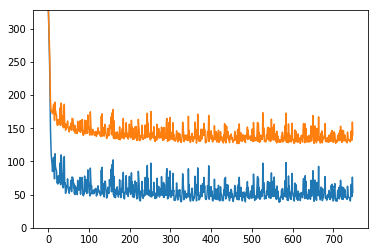

In [26]:
plt.plot(y0,label="training")
plt.plot(y1,label="dev")
plt.ylim([0,max(y1)])